# PART II: TRAJECTORY CLASSIFICATION USING RNN

In [29]:
#%pip install tensorflow
import tensorflow as tf
from sklearn.metrics import confusion_matrix

import numpy as np
import random

import pandas as pd
import geopandas as gpd
from shapely import Point
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import seaborn as sns


In [69]:
gdf = gpd.read_file("C:/Users/anape/Downloads/outsight/alb_output/geodata/fake3.geoJSON")

## Data Normalization & Dimensionality Reduction

Using the labeled trajectories dataset, I can train a model to categorize trajectories into the 11 identified paths (clusters). This kind of model would be valuable for analyzing real-time incoming traffic data by classifying objects' trajectories as it could offer insights into traffic flow and patterns at any given time. Deriving traffic flow statistics would be as simple as tallying the occurrences per path.

Trajectory data is sequential by nature because it captures the movement of objects over time. Each trajectory consists of a sequence of spatial coordinates (latitude, longitude) collected at different time intervals. Recurrent Neural Networks (RNNs) are well-suited for processing sequential data due to their ability to capture temporal dependencies and patterns within sequences. As RNNs process each step in the sequence, they maintain a hidden state that retains information from previous steps, allowing the model to learn temporal dependencies.

Before carrying on, it is important to understand the shape of the data. I know that I have 525 trajectories, split into 11 classes. But each trajectory might have a different length, based on how long the object was tracked for or how fast it was moving. Below is a histogram of the points per trajectory for my dataset.

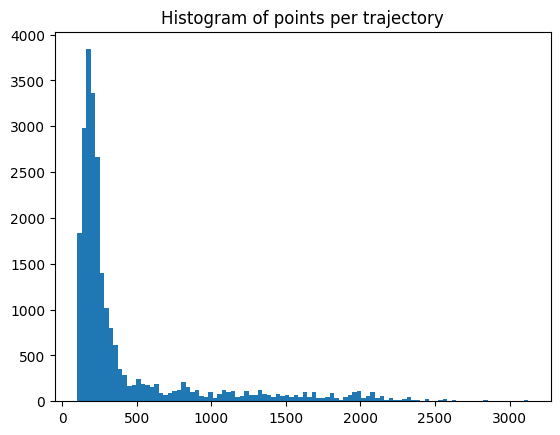

In [32]:
trajectories = list(gdf['geometry'])
points = [len(list(trajectory.coords)) for trajectory in trajectories]
plt.hist(points, bins=100)
plt.title('Histogram of points per trajectory')
plt.show()

Trajectories vary widely in length, ranging from as few as 100 data points to over 3000. RNNs handle variable-length sequences well and are flexible for data of different lengths.

However, for a simple pipeline, having data of consistent dimensionality would make things much much easier. And it would particularly great if the number of dimensions isn't excessively high, like 3000.

Simplifying polyline tasks can use algorithms like sliding window or RDP (Ramer-Douglas-Peucker, the standard in cartography). I'll opt for a more straightforward approach: line interpolation.

Line interpolation turns variable-length trajectories into uniform sequences of points. Interpolation evenly distributes a fixed number of points along each trajectory. The process estimates new points along the trajectory by calculating positions at regular intervals between the existing data points. The result is smoother representations of the trajectories using just a small part of the original points. This simplies analysis and modeling.

Given that the trajectories in question are not particularly complicated, the number of points for the interpolation can be modest. After some experimentation, I found out a value as low as 10 suffices. 20 points provide sufficient granularity while keeping the trajectories fairly simple.

Below you can see visualizations of the interpolation and its results.

In [99]:
interpolated_trajectories = []

num_points = 100
trajectories = list(gdf['geometry'])

# Interpolate each trajectory to have the same number of points
for trajectory in trajectories:
    interpolated_points = [trajectory.interpolate(i / (num_points - 1), normalized=True) for i in range(num_points)]
    interpolated_trajectory = LineString(interpolated_points)
    interpolated_trajectories.append(interpolated_trajectory)

# Store in a new dataframe
interpolated_gdf = gpd.GeoDataFrame({'geometry': interpolated_trajectories,'cluster':gdf['cluster']})

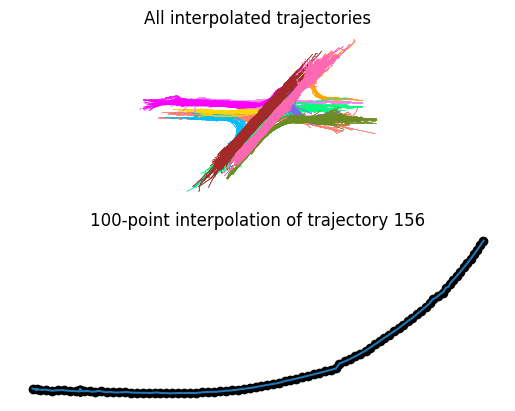

In [100]:
color_map = {
    0: 'salmon', 1: 'deepskyblue', 2: 'gold', 3: 'orange', 4: 'violet',
    5: 'springgreen', 6: 'mediumslateblue', 7: 'magenta', 8: 'brown', 9: 'olivedrab', 10: 'hotpink'
}
colors = interpolated_gdf['cluster'].map(color_map)


fig,axes = plt.subplots(2,1)
ax = axes[0]
interpolated_gdf.plot(color=colors, linewidth=0.3, ax=ax)
ax.set_title('All interpolated trajectories')
ax.axis('off')

ax=axes[1]
original = gdf['geometry'].iloc[156].xy
interpolated = interpolated_gdf['geometry'].iloc[156].xy
ax.plot(original[0],original[1])
ax.scatter(interpolated[0],interpolated[1],color='black')
ax.set_title(f'{num_points}-point interpolation of trajectory 156')
ax.axis('off')
plt.show()

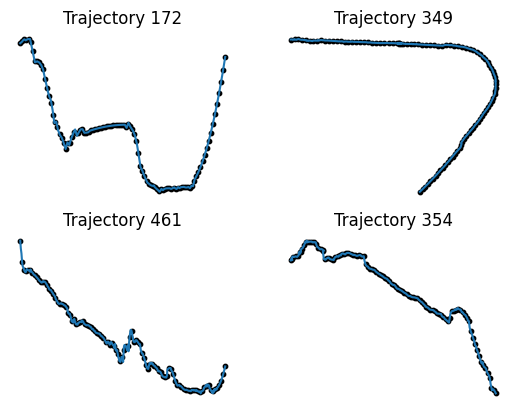

In [101]:
fig,axes = plt.subplots(2,2)
flat_axes = axes.ravel()

for k in range(0,4):
    ax=flat_axes[k]
    i = random.randint(0,525)
    original = gdf['geometry'].iloc[i].xy
    interpolated = interpolated_gdf['geometry'].iloc[i].xy

    #gdf.plot(color='lightgray', linewidth=0.3, ax=ax)

    ax.plot(original[0],original[1])
    ax.scatter(interpolated[0],interpolated[1],color='black',s=10)
    ax.set_title(f'Trajectory {i}')
    ax.axis('off')
plt.show()

In [102]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is called 'df'
# df is your original dataframe

# Splitting the DataFrame into 80% training and 20% testing
train_gdf, test_gdf = train_test_split(interpolated_gdf, test_size=0.2, random_state=42)

Note that the interpolated points are not uniformly spaced concerning spatial increments. Interpolation is done is respect to the temporal aspect and since moving speed is not uniform, there two aspects - spatial and temporal - are not equivalent. The number of points per trajectory depends on the temporal aspect of movement. Instances where the object moved slowly result in a higher density of points, while faster movements lead to more spaced-out points.

Also note that while plotted all together, the trajectories look smooth and fairly similar, but when inspected individually, the noise in the data becomes more obvious.

## Recurrent Neural Network

I use a simple RNN implemented with the `tensorflow` library. The model architecture consists of 4 layers:

1. Input layer, which is implicitly defined by specifying `input_shape` in the first (technically second) SimpleRNN layer. `input_dim` is the number of features at each time step (2, x and y coordinates), and `seq_length` is the length of the input sequences (20, as per the line interpolation process above).

2. Next is a SimpleRNN layer with 32 neurons. It reshapes the input data from 2 to 32 dimensions. The choice of 32 neurons was arbitrary, following some trials. Each neuron processes the input features at a specific time step and maintains a hidden state that is updated as the sequence progresses. The processing uses both the current input and the previous hidden state to update the internal representation of the sequence.
 
    At time step $t$:
    $$h_t = \text{ReLU}(x_t \times W_{hx} + h_{t-1} \times W_{hh} + b)$$

    where:
    - $ x_t $ is the current input at time $ t $.
    - $ h_t $ is the updated hidden state at time $t$.
    - $ W_{hx} $ is the weight matrix of the input (how much it contributes to the hidden state).
    - $ W_{hh} $ is the weight matrix of the previous hidden state (how much it contributes to the current hidden state).
    - $ b $ is the bias term.
    - The ReLU activation introduces non-linearity to the model.

3. Next is a dense (fully connected) layer with 16 neurons, which takes the output from the SimpleRNN layer (32 dimensions) and applies a linear transformation followed by the ReLU activation to extract higher-level representations from the sequence. The output of this layer has 16 dimensions.

4. Final is the output layer, which is also dense but uses the softmax activation function. The softmax function ensures that the sum of the output probabilities is 1 so the model is able to do categorical predictions.  The layer transforms the extracted features into a probability distribution across 11 classes.


The RNN model is solving an optimization problem, adjusting the parameters (weight matrices and bias) to minimize a loss function (disparity of predictions vs true labels).

The training has 20 epochs, meaning the entire dataset will be iterated over 20 times during training. The `validation_split` of 0.2 designates 20% of the training data to be used as a validation set to assess the model's performance and prevent overfitting during training. I choose a small split to retain more samples for training, given that my dataset is fairly small.

In [103]:
seq_length = num_points
input_dim = 2 # x and y

n = len(train_gdf)
train_data = np.array([train_gdf['geometry'].iloc[k].xy for k in range(n)])
labels = np.array(train_gdf['cluster'])

# Model architecture
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, input_shape=(input_dim, seq_length), activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
%pip install pydot
from tensorflow.keras.utils import plot_model


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


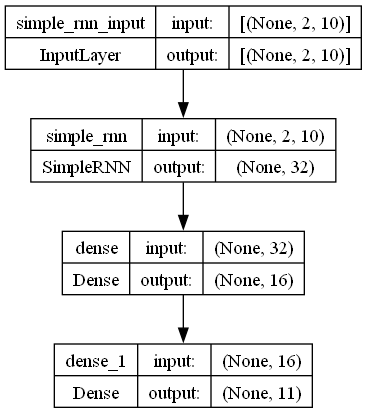

In [14]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [104]:
# Train the model
history = model.fit(train_data, labels, epochs=10, validation_split=0.3)

Epoch 1/10
156/156 [==============================] - 2s 5ms/step - loss: 4.1498 - accuracy: 0.2543 - val_loss: 1.6244 - val_accuracy: 0.3360
Epoch 2/10
156/156 [==============================] - 0s 3ms/step - loss: 1.3526 - accuracy: 0.4421 - val_loss: 1.0774 - val_accuracy: 0.5576
Epoch 3/10
156/156 [==============================] - 0s 3ms/step - loss: 0.8466 - accuracy: 0.7524 - val_loss: 0.6071 - val_accuracy: 0.8664
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.4619 - accuracy: 0.8998 - val_loss: 0.3614 - val_accuracy: 0.9147
Epoch 5/10
156/156 [==============================] - 0s 3ms/step - loss: 0.2867 - accuracy: 0.9550 - val_loss: 0.2328 - val_accuracy: 0.9841
Epoch 6/10
156/156 [==============================] - 0s 3ms/step - loss: 0.1953 - accuracy: 0.9882 - val_loss: 0.1757 - val_accuracy: 0.9869
Epoch 7/10
156/156 [==============================] - 0s 3ms/step - loss: 0.1529 - accuracy: 0.9914 - val_loss: 0.1479 - val_accuracy: 0.9902
Epoch 

Tracking the training and validation accuracy over the epochs helps in understanding how well the model performs on both the training and validation sets and whether there are signs of overfitting (if the validation accuracy diverges significantly from the training accuracy). A visualization is provided below.

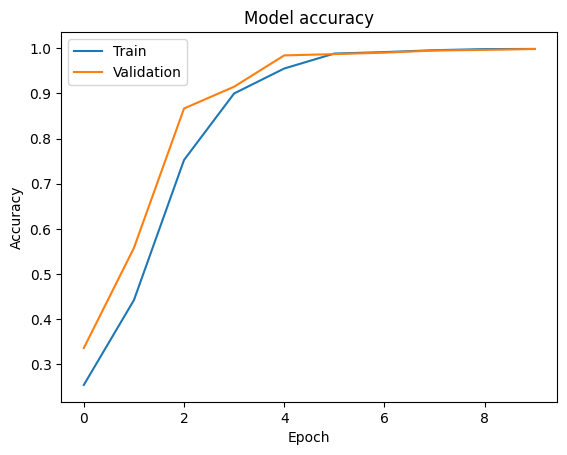

In [105]:
#history = model.fit(data, labels, epochs=10,  validation_split=0.5)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [92]:
history.history['accuracy']

[0.4432617127895355,
 0.7226350903511047,
 0.9576219916343689,
 0.9897570013999939,
 0.9943763613700867,
 0.9969873428344727,
 0.9977906942367554,
 0.9983932375907898,
 0.9991966485977173,
 0.9995983242988586]

The model achieved high accuracy (around 99%) on the training data across all epochs, indicating it learned well from the training set. There is similar performance gap on the validation set, with accuracy close to 100%, suggesting the model extrapolates well on unseen data.

To intepret the model's inner workings, I look into the confusion matrix.

In [106]:
n = len(test_gdf)
test_data = np.array([test_gdf['geometry'].iloc[k].xy for k in range(n)])
labels = np.array(test_gdf['cluster'])


Epoch 1/10
46/56 [=======================>......] - ETA: 0s - loss: 0.0034 - accuracy: 0.9993

56/56 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.9994
Epoch 2/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9994
Epoch 3/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 4/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 5/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 6/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 7/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 8/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 9/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 10/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000


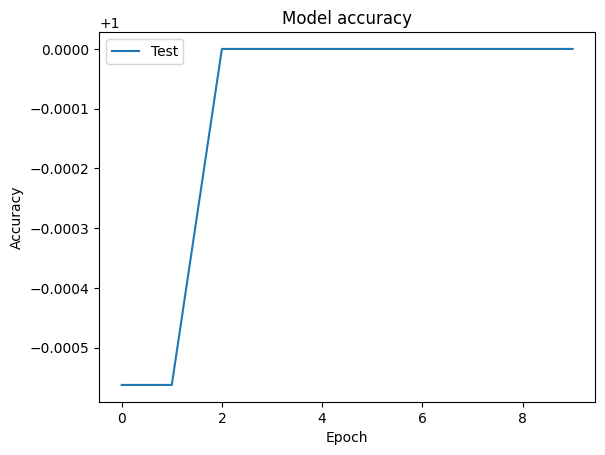

In [108]:
history = model.fit(test_data, labels, epochs=10)

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Test'], loc='upper left')
plt.show()

56/56 [==============================] - 0s 2ms/step


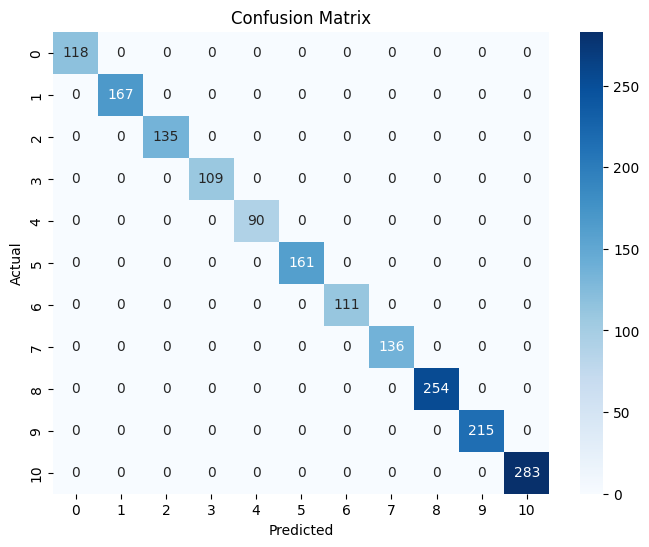

In [109]:
predictions = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


The confusion matrix shows the model performs very well.

## Activation maximization

In [110]:
def activation_maximization(label_index, num_iterations=100, learning_rate=0.1):
    # Initialize with random data
    input_data = np.random.random((1, input_dim, seq_length))  
    label_tensor = tf.convert_to_tensor([[label_index]])  # Target label tensor
    input_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
    
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(input_tensor)
            predictions = model(input_data)
            loss = -predictions[:, label_index]  # Loss is the negative activation of the target neuron

        gradients = tape.gradient(loss, input_tensor)
        
        if gradients is not None:
            gradients /= (tf.norm(gradients) + 1e-8)  # Adding a small epsilon for numerical stability
            input_tensor += learning_rate * gradients  # Update input data

    return input_tensor

# activation maximization for each label
maximized_inputs = []
for label_index in range(11):
    maximized_input = activation_maximization(label_index)
    maximized_inputs.append(maximized_input)


# Perform activation maximization for each label
maximized_inputs = []
for label_index in range(11):
    maximized_input = activation_maximization(label_index)
    maximized_inputs.append(maximized_input)


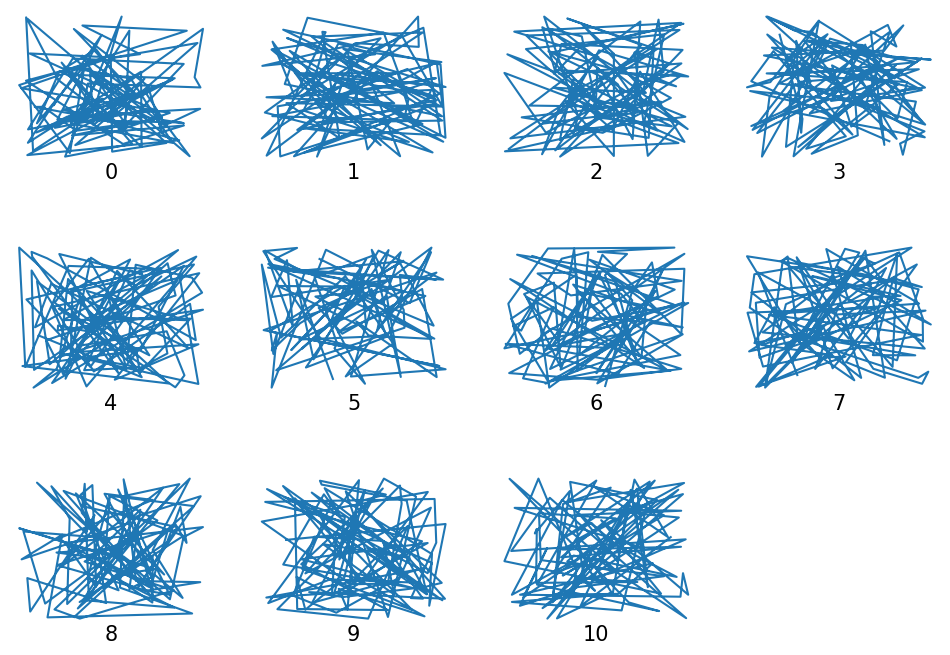

In [111]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i in range(11):
    ax = axes.flatten()[i]
    ax.plot(maximized_inputs[i][0][0],maximized_inputs[i][0][1])
    ax.text(0.5, -0.1, f'{i}', fontsize=15, color='black', ha='center', transform=ax.transAxes)
    ax.axis('off')

plt.subplots_adjust(hspace=0.5)
plt.axis('off')
plt.show()